# VQ-MAP model inference

Here we demonstrate how to run inference using a trained VQ-MAP model easily inside a Jupyter notebook.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from csbev.core.inference import InferenceHelper
from utils import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download data and model

Download from [here](https://duke.box.com/s/n9l5swmdbyg94z0o94meh1wv4bv1ao36) and place under `demo/`.

## Load model

In [4]:
# PUT YOUR EXPERIMENT PATH HERE
# which should contain everything needed for inference after a typical training, `checkpoints`, `config.yaml`, etc.
EXPROOT = "./model"

# Load experiment information
config, model, skeletons, codebook_vecs, code_duration, codebook_size = load_experiment(EXPROOT)

Avilable skeletons: dict_keys(['rat23'])
Model loaded from Epoch 449
All codebooks:
bottleneck.sub_quantizers.0.codebook torch.Size([8, 64])
bottleneck.sub_quantizers.1.codebook torch.Size([16, 64])
Codebook size: [8, 16]
Code duration: 16


## Load dataset

In [5]:
# Load dataset we want to run inference on
# here we override the `rat23` dataset config under `configs/dataset`
# with the data npy file we just downloaded
dataset_loading_params = {
    "rat23": {
        "dataset_name": "rat23",
        "filter_keys": [""], # setting empty to use all 30 recordings
        "datafile": [
            './data/SCN2A_WK1.npy'
        ]
    },
}
datasets = {}
datapaths = {}
for tag, load_params in dataset_loading_params.items():
    datasets[tag], skeletons[tag], datapaths[tag] = load_dataset_fron_config(**load_params, return_datapaths=True)

# prepare loaders
dataloaders = {
    tag: DataLoader(dataset, batch_size=64, shuffle=False)
    for tag, dataset in datasets.items()
}
# dataset scale factors, placeholders only
dataset_scales = {}
for tag, dataset in datasets.items():
    if isinstance(dataset, torch.utils.data.Subset):
        dataset_scales[tag] = dataset.dataset.scale
    else:
        dataset_scales[tag] = dataset.scale

2025-07-26 19:49:41.636 | INFO     | csbev.dataset.base:__init__:72 - Processing with torch: True (device: cuda:0)
2025-07-26 19:49:41.636 | WARNING  | csbev.dataset.base:__init__:77 - Random shuffle: None


Loading n=30 datafiles ['2022_09_15_M1', '2022_09_15_M2', '2022_09_15_M3', '2022_09_15_M4', '2022_09_15_M5', '2022_09_15_M6', '2022_09_16_M1', '2022_09_16_M2', '2022_09_16_M3', '2022_09_16_M4', '2022_09_16_M5', '2022_09_16_M6', '2022_09_17_M1', '2022_09_17_M2', '2022_09_17_M3', '2022_09_17_M4', '2022_09_17_M5', '2022_09_17_M6', '2022_09_18_M1', '2022_09_18_M2', '2022_09_18_M3', '2022_09_18_M4', '2022_09_18_M5', '2022_09_18_M6', '2022_09_19_M1', '2022_09_19_M2', '2022_09_19_M3', '2022_09_19_M4', '2022_09_19_M5', '2022_09_19_M6']


Preprocess: 100%|██████████| 30/30 [00:01<00:00, 17.71it/s]
2025-07-26 19:49:44.355 | INFO     | csbev.dataset.base:_postproc_data:211 - Dataset rat23: torch.Size([2699520, 23, 3])


## Run inference

Running the following block and all results will be found under `EXPROOT/analysis`.

100%|██████████| 330/330 [00:21<00:00, 15.08it/s]


Saving embeddings torch.Size([168720, 2]) for rat23 to ./model/analysis/embeddings


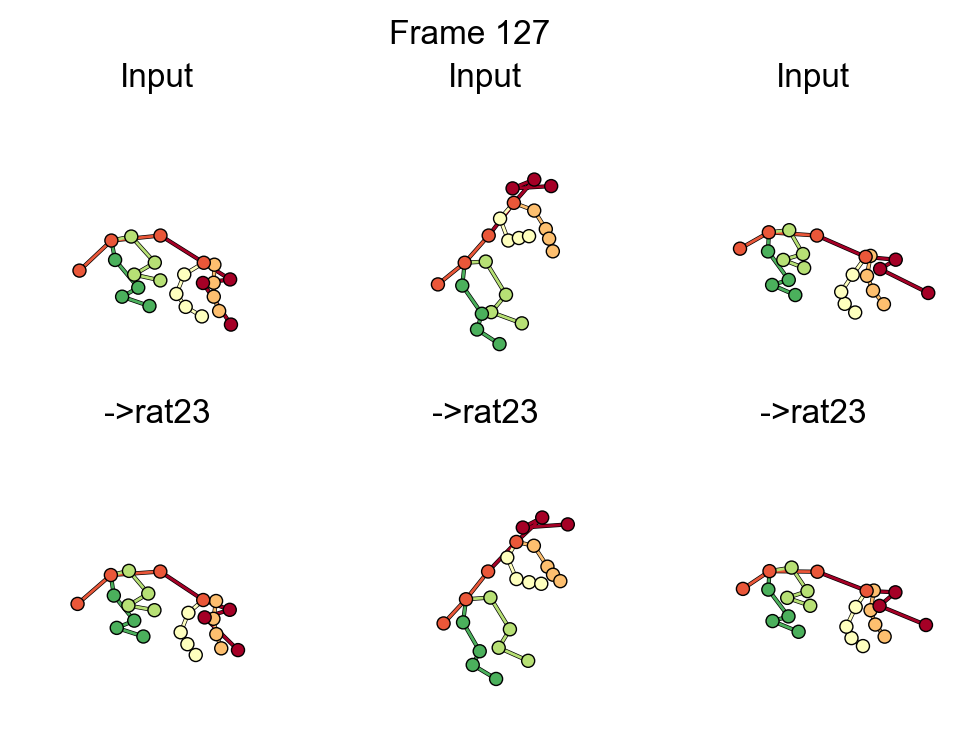

In [6]:
# Create the inference helper
inference_cfg = OmegaConf.load('../configs/inference.yaml')
inference_cfg.result_root = os.path.join(EXPROOT, 'analysis')
helper = InferenceHelper(
    cfg=inference_cfg,
    skeletons=skeletons,
    dataset_scales=dataset_scales,
    dataloaders=dataloaders,
    model=model,
)
# visualize the discrete latent space
helper.sample()
# visualize the reconstruction results as videos
helper.vis_reconstruction(n_samples=3)
# embed all datasets, should be very fast
helper.embed()

### Taking a closer look at the latent space

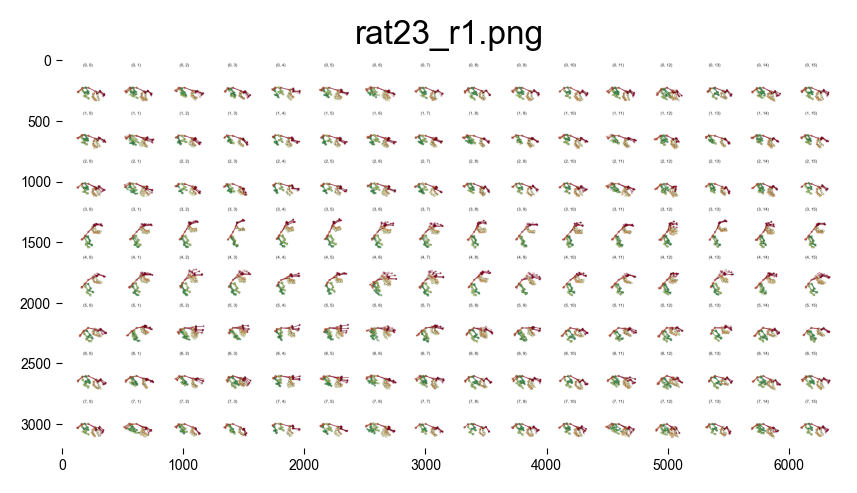

In [8]:
vis_latent_space(EXPROOT)

### Visualize video how VQ-MAP reconstructs the pose time series

In [7]:
video_path = os.path.join(EXPROOT, 'analysis/reconstruction/reconstruction_rat23.mp4')
if os.path.exists(video_path):
    from IPython.display import Video
    display(Video(video_path, embed=True, width=640, height=480))